In [407]:
import scipy.stats as stats
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import math
import acor
%matplotlib inline

In [78]:
dist = stats.beta(1, 1)

In [79]:
measurements = []
for i in range(30):
    cosi = dist.rvs(1)[0]
    noise = stat.norm(cosi, 0.05).rvs(100)
    measurements.append(noise)

Alpha = 0.490606661811, Beta = 0.656474283919


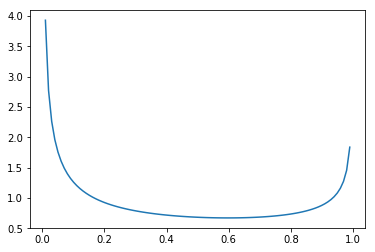

In [81]:
# P(alpha) ~ 1
alpha = stats.uniform.rvs()
# P(beta) ~ 1
beta = stats.uniform.rvs()
print "Alpha = {}, Beta = {}".format(alpha, beta)
# P(COSI) = Beta(alpha, beta)
guess = stats.beta(alpha, beta)
plt.plot(np.linspace(0, 1, 100), guess.pdf(np.linspace(0, 1, 100)))

(array([ 5.,  4.,  3.,  3.,  4.,  2.,  2.,  3.,  1.,  3.]),
 array([ 0.01341934,  0.11155421,  0.20968908,  0.30782395,  0.40595882,
         0.50409369,  0.60222856,  0.70036343,  0.79849831,  0.89663318,
         0.99476805]),
 <a list of 10 Patch objects>)

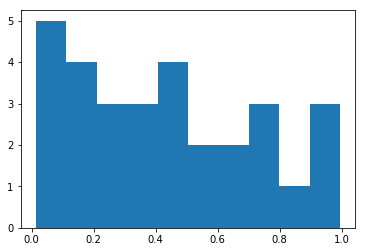

In [82]:
new_samples = []
for measurement in measurements:
    # P(x | COSI)
    probs = guess.pdf(measurements[0])
    probs = np.divide(probs, np.sum(probs))
    # Pick a sample
    sample = np.random.choice(measurement, p=probs)
    new_samples.append(sample)
plt.hist(new_samples)

In [88]:
N = 1000

alphas = np.zeros(N)
betas = np.zeros(N)
# P(alpha) ~ 1
# alpha = stats.uniform.rvs()
alpha = 0.4
# P(beta) ~ 1
# beta = stats.uniform.rvs()
beta = 0.7
print "Alpha = {}, Beta = {}".format(alpha, beta)
# P(COSI) = Beta(alpha, beta)
guess = stats.beta(alpha, beta)

for i in range(N):
    # Pick samples given alpha, beta
    new_samples = []
    for measurement in measurements:
        # P(x | COSI)
        probs = guess.pdf(measurements[0])
        probs = np.divide(probs, np.sum(probs))
        # Pick a sample
        sample = np.random.choice(measurement, p=probs)
        new_samples.append(sample)
    # Pick a new alpha and beta given samples
    alpha, beta, _, _ = stats.beta.fit(new_samples)
    guess = stats.beta(alpha, beta)
    alphas[i] = alpha
    betas[i] = beta


Alpha = 0.4, Beta = 0.7


In [219]:
def mcmc(_lgprob, args, ndim=1, nwalkers=50, nburn=500, nsteps=2000):
    # we'll start at random locations between 0 and 8
    starting_guesses = 8 * np.random.rand(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, _lgprob, args=args)
    sampler.run_mcmc(starting_guesses, nsteps)

    sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
    sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points
    return sample

In [233]:
def get_alpha_mcmc(beta, samples, plot=False, nwalkers=50, nsteps=2000):
    
    # log-posterior for P(alpha | beta, samples)
    def _lgprob(alpha, beta, samples, N):
        if alpha + beta < 0:
            return -np.inf
        if alpha < 0:
            return -np.inf
        if alpha + beta > 20:
            return -np.inf
        if alpha > 20:
            return -np.inf
        
        return N * (math.log(gamma(alpha + beta)) - math.log(gamma(alpha))) + np.sum(alpha * np.log(samples))

    sample = mcmc(_lgprob, [beta, samples, len(samples)], nwalkers=nwalkers, nsteps=nsteps)
    
    if plot:
        plt.hist(sample)
    
    return sample

In [234]:
def get_beta_mcmc(alpha, samples, plot=False, nwalkers=50, nsteps=2000):
    
    # log-posterior for P(beta | alpha, samples)
    def _lgprob(beta, alpha, samples, N):
        if alpha + beta < 0:
            return -np.inf
        if beta < 0:
            return -np.inf
        if alpha + beta > 20:
            return -np.inf
        if beta > 20:
            return -np.inf
        
        return N * (math.log(gamma(alpha + beta)) - math.log(gamma(beta))) + np.sum(beta * np.log(1 - samples))

    sample = mcmc(_lgprob, [alpha, samples, len(samples)], nwalkers=nwalkers, nsteps=nsteps)
    
    if plot:
        plt.hist(sample)
    
    return sample

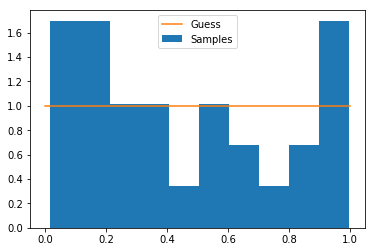

In [180]:
N = 30
dist = stats.beta(0.75, 0.75)
measurements = []
for i in range(N):
    cosi = dist.rvs(1)[0]
    noise = stats.norm(cosi, 0.05).rvs(100)
    measurements.append(noise)

alpha = 1
beta = 1
guess = stats.beta(alpha, beta)

# Draw new samples from P(COSI_i | alpha, beta)
samples = np.zeros(N)
for i in range(N):
    probs = guess.pdf(measurements[i])
    probs /= np.sum(probs)
    samples[i] = np.random.choice(measurements[i], p=probs)

plt.hist(samples, normed=True, label="Samples")
plt.plot(np.linspace(0, 1, 1000), guess.pdf(np.linspace(0, 1, 1000)), label="Guess")
plt.legend()

0.751027517401 1.07775489683


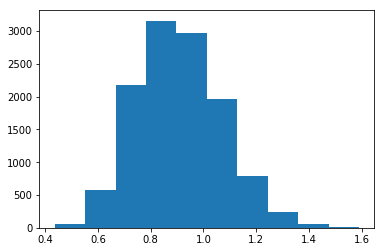

In [196]:
# Draw new samples from P(alpha | COSI, beta)
a = get_alpha(0.83, samples, plot=True, nwalkers=12, nsteps=2000)
print a[0],  a[-1]

0.97217181376889483

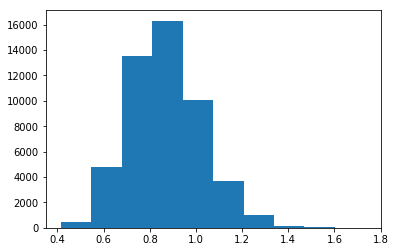

In [197]:
get_beta(1.08, samples, plot=True)[-1]

In [264]:
def get_samples(alpha, beta, measurements):
    guess = stats.beta(alpha, beta)
    # Draw new samples from P(COSI_i | alpha, beta)
    N = len(measurements)
    samples = np.zeros(N)
    for i in range(N):
        probs = guess.pdf(measurements[i])
        probs /= np.sum(probs)
        samples[i] = np.random.choice(measurements[i], p=probs)
    return samples

In [172]:
def get_measurements(alpha, beta, N=30, noise_draws=100, plot=False):
    dist = stats.beta(alpha, beta)
    measurements = np.zeros((N, noise_draws))
    for i in range(N):
        cosi = dist.rvs(1)[0]
        noise = stats.norm(cosi, 0.05).rvs(noise_draws)
        noise = noise[noise > 0]
        measurements[i] = noise
    if plot:
        plt.hist(np.median(measurements, axis=1), normed=True, label="Data")
        plt.plot(np.linspace(0, 1, 1000), dist.pdf(np.linspace(0, 1, 1000)), label="Population")
        plt.legend()
    return measurements

# Using N = 31 samples

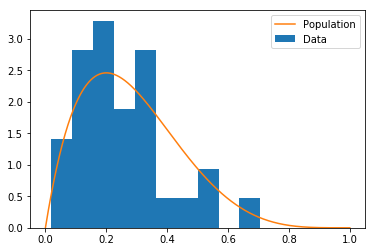

In [144]:
measurements = get_measurements(2, 5, N=31)

In [145]:
niter = 100
alphas = np.zeros(niter)
betas = np.zeros(niter)

alphas[0] = 1
betas[0] = 1

for i in range(1, niter):
    samples = get_samples(alphas[i - 1], betas[i - 1], measurements)
    alphas[i] = get_alpha(alphas[i - 1], betas[i - 1], samples, nwalkers=10)[-1]
    betas[i] = get_beta(alphas[i - 1], betas[i - 1], samples, nwalkers=10)[-1]

[ 1.          0.75256404  0.64726202  0.6615618   0.65387928  0.39970843
  0.40355934  0.68365758  0.92301245  0.72266598  0.42007058  0.52277165
  0.6375104   0.53644611  0.56559215  0.54543951  0.81487185  0.7651051
  0.840016    0.57282925  0.44621585  0.697625    0.70090403  0.32994992
  0.72534774  0.5952445   0.47868462  0.584525    0.70923593  0.60259493
  0.83817871  0.46628579  0.61511218  0.73357954  0.44789611  0.49772425
  0.56793622  0.69467007  0.73379543  0.532495    0.45460535  0.76903772
  0.67574501  0.61225261  0.61973053  0.53941559  0.58512159  0.68658534
  0.5611924   0.52868303  0.54976687  0.65104615  0.62200893  0.67000229
  0.62699042  0.66822526  0.45701905  0.57270504  0.43675648  0.4283482
  0.48172856  0.47255457  0.37485027  0.88677423  0.56932709  0.43318276
  0.63081888  0.6797418   0.64199688  0.63047533  0.717224    0.69506406
  0.66119256  0.48624701  0.55601767  0.39941942  0.76494977  0.65174385
  0.42745265  0.51496444  0.54667617  0.70759004  0.5

(array([  2.,  15.,  14.,  22.,  18.,  17.,   6.,   3.,   2.,   1.]),
 array([ 0.32994992,  0.39695493,  0.46395994,  0.53096494,  0.59796995,
         0.66497496,  0.73197997,  0.79898498,  0.86598998,  0.93299499,  1.        ]),
 <a list of 10 Patch objects>)

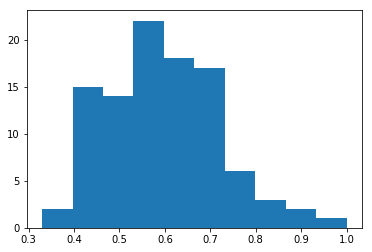

In [148]:
print alphas
plt.hist(alphas)

[ 1.          2.9089616   3.03602544  3.07567381  4.65732374  3.29580863
  3.56359466  2.98753294  2.7280956   4.19608333  4.0171505   3.32740765
  2.9358524   3.33302917  2.99040831  4.01667299  3.13377696  3.06270494
  4.09440578  3.37977559  3.24477481  4.23803566  3.6400866   2.59254275
  3.30426959  4.20980792  3.56655483  3.15235929  3.7218698   3.93613825
  3.37912383  3.83228783  2.82507792  2.17362007  2.96924416  2.98986337
  3.97116456  3.20316513  3.33731341  4.29233416  3.34241912  4.6651873
  3.68370099  2.97792826  3.57023363  3.38291314  2.7070467   3.69936416
  3.32015307  3.33912226  4.38358372  3.31762403  4.41068663  3.39812811
  3.14723117  3.26994319  3.06680085  2.92923778  3.23261094  2.65284824
  4.09628921  2.90479682  3.69419406  3.25740869  2.75517629  3.23775667
  2.73864713  2.74582703  2.85412393  2.49954497  4.54279984  3.34164062
  4.21460039  3.0921124   4.12130281  3.10510152  3.73669813  2.88126317
  3.7038889   3.38661766  3.41217589  2.9199715   2.

(array([  1.,   0.,   0.,   2.,  16.,  28.,  26.,  11.,  12.,   4.]),
 array([ 1.        ,  1.38393017,  1.76786033,  2.1517905 ,  2.53572066,
         2.91965083,  3.30358099,  3.68751116,  4.07144132,  4.45537149,
         4.83930165]),
 <a list of 10 Patch objects>)

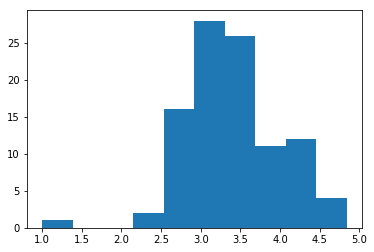

In [147]:
print betas
plt.hist(betas)

In [151]:
best_guess_alpha = np.median(alphas)

In [152]:
best_guess_beta = np.median(betas)

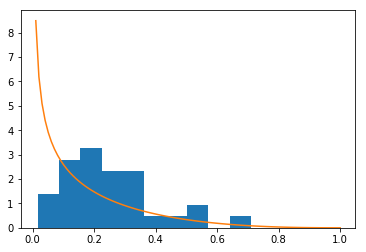

In [158]:
plt.hist(np.median(measurements, axis=1), normed=True, label="Data")
plt.plot(np.linspace(0, 1, 100), stats.beta(best_guess_alpha, best_guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")

In [220]:
def run_simulation(pop_alpha, pop_beta, N, guess_alpha=1, guess_beta=1, niter=1000):
    measurements = get_measurements(pop_alpha, pop_beta, N=N)
    
    plt.hist(np.median(measurements, axis=1), normed=True, label="Data")
    plt.plot(np.linspace(0, 1, 100), stats.beta(pop_alpha, pop_beta).pdf(np.linspace(0, 1, 100)), label="Population")
    plt.plot(np.linspace(0, 1, 100), stats.beta(guess_alpha, guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")
    plt.legend()
    plt.show()
    
    alphas = np.zeros(niter)
    betas = np.zeros(niter)
    
    alphas[0] = guess_beta
    betas[0] = guess_beta

    # Gibbs Sampling
    for i in range(1, niter):
        # Draw x_i ~ P(x_i | alpha_i-1, beta_i-1)
        samples = get_samples(alphas[i - 1], betas[i - 1], measurements)
        # Draw alpha_i ~ P(alpha_i | x_i, beta_i-1)
        alphas[i] = get_alpha(betas[i - 1], samples, nwalkers=10, nsteps=1000)[-1]
        # Draw beta_i ~ P(beta_i | x_i, alpha_i)
        betas[i] = get_beta(alphas[i], samples, nwalkers=10, nsteps=1000)[-1]
    
    best_guess_alpha = np.median(alphas)
    best_guess_beta = np.median(betas)
    
    f, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.hist(alphas)
    ax2.hist(betas)
    
    ax3.hist(np.median(measurements, axis=1), normed=True, label="Data")
    ax3.plot(np.linspace(0, 1, 100), stats.beta(best_guess_alpha, best_guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")
    ax3.legend()
    plt.tight_layout()
    plt.show()
    
    return alphas, betas

array([[ 0.26011429,  0.24797141,  0.33243261, ...,  0.26620277,
         0.27007506,  0.20200732],
       [ 0.22153272,  0.21947455,  0.29162631, ...,  0.13939001,
         0.16428198,  0.21626107],
       [ 0.07498658,  0.01613964,  0.05168805, ...,  0.04177696,
         0.02954251,  0.03943147],
       ..., 
       [ 0.7603313 ,  0.76765817,  0.8015768 , ...,  0.8096813 ,
         0.83017409,  0.86064847],
       [ 0.14228517,  0.14528968,  0.2086577 , ...,  0.07898269,
         0.13500917,  0.06548457],
       [ 0.08041096,  0.07329913,  0.08891978, ...,  0.14873596,
         0.10474539,  0.12781567]])

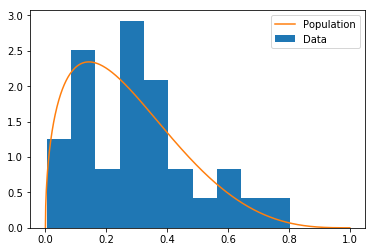

In [221]:
get_measurements(1.5, 4, plot=True)

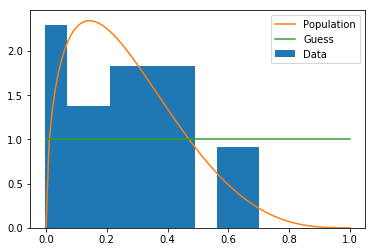

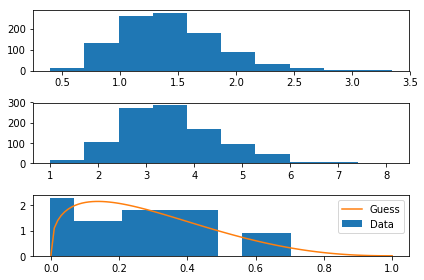

In [222]:
alphas, betas = run_simulation(1.5, 4, 31, niter=1000)

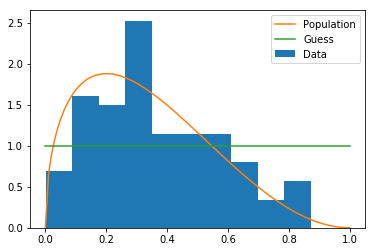

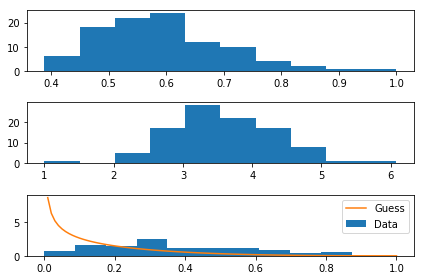

In [178]:
run_simulation(1.5, 3, 100, niter=100)

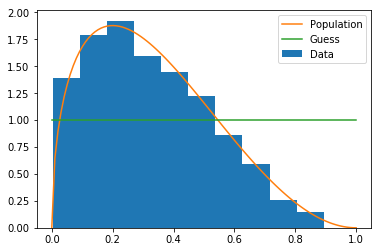

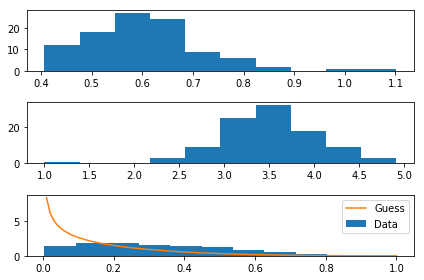

In [179]:
run_simulation(1.5, 3, 1000, niter=100)

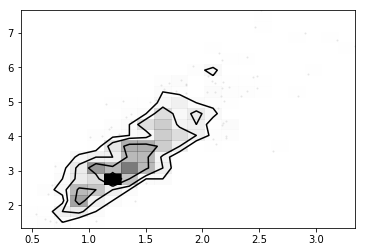

In [228]:
corner.hist2d(alphas[500:], betas[500:])

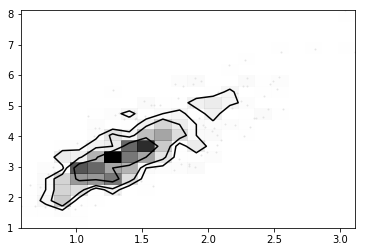

In [229]:
corner.hist2d(alphas[:500], betas[:500])

In [244]:
from scipy.stats import expon
prop = expon(scale=1/0.25)
new_alpha = prop.rvs(1)[0]
print new_alpha
prob_new_alpha = prop.pdf(new_alpha)
print prob_new_alpha

6.54290068904
0.0487027621238


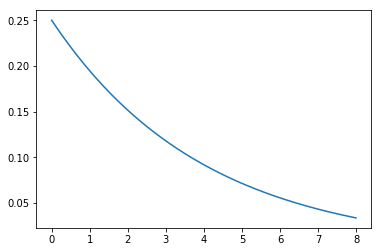

In [232]:
plt.plot(np.linspace(0, 8, 1000), expon.pdf(np.linspace(0, 8, 1000), scale=1/0.25))

In [406]:
def get_alpha_mh(alpha, beta, samples):
    # log-posterior for P(alpha | beta, samples)
    def _lgprob(alpha, beta, samples, N):
        if alpha + beta < 0:
            return -np.inf
        if alpha < 0:
            return -np.inf
        if alpha + beta > 20:
            return -np.inf
        if alpha > 20:
            return -np.inf
        
        return N * (math.log(gamma(alpha + beta)) - math.log(gamma(alpha))) + np.sum(alpha * np.log(samples))

    # Draw new alpha from proposal distribution
    prop = expon(scale=1/0.25)
    
    new_alpha = prop.rvs(1)[0]
    
    prob_new_alpha = prop.pdf(new_alpha)
    prob_old_alpha = prop.pdf(alpha)
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = _lgprob(new_alpha, beta, samples, len(samples)) - _lgprob(alpha, beta, samples, len(samples))
    lg_a2 = math.log(prob_old_alpha) - math.log(prob_new_alpha)
    
    lg_a = lg_a1 + lg_a2
    
    a = math.exp(lg_a)
    
    if a > 1:
        return new_alpha
    else:
        r = np.random.uniform()
        if r < a:
            return new_alpha
        else:
            return alpha

In [405]:
def get_beta_mh(alpha, beta, samples):
    # log-posterior for P(beta | alpha, samples)
    def _lgprob(beta, alpha, samples, N):
        if alpha + beta < 0:
            return -np.inf
        if beta < 0:
            return -np.inf
        if alpha + beta > 20:
            return -np.inf
        if beta > 20:
            return -np.inf
        
        return N * (math.log(gamma(alpha + beta)) - math.log(gamma(beta))) + np.sum(beta * np.log(1 - samples))

    # Draw new alpha from proposal distribution
    prop = expon(scale=1/0.25)
    
    new_beta = prop.rvs(1)[0]
    
    prob_new_beta = prop.pdf(new_beta)
    prob_old_beta = prop.pdf(beta)
    
    # MH-Step
    # a = a_1 * a_2
    # a_1 = P(new) / P(old)
    # a_2 = Q(old) / Q(new)
    # Accept with prob a if a <= 1
    # lg(a) = lg(a_1) + lg(a2)
    # lg(a) = lg(P(new)) - lg(P(old)) + lg(Q(old)) - lg(Q(new))
    # Accept with prob a if lg(a) <= 0
    
    lg_a1 = _lgprob(new_beta, alpha, samples, len(samples)) - _lgprob(beta, alpha, samples, len(samples))
    lg_a2 = math.log(prob_old_beta) - math.log(prob_new_beta)
    
    lg_a = lg_a1 + lg_a2
    
    a = math.exp(lg_a)
    
    if a > 1:
        return new_beta
    else:
        r = np.random.uniform()
        if r < a:
            return new_beta
        else:
            return beta

In [287]:
curr_alpha = 1
curr_beta = 1

N = 1000
alphas = np.zeros(N)
betas = np.zeros(N)
alphas[0] = curr_alpha
betas[0] = curr_beta
for i in range(1, N):
    samples = get_samples(alphas[i - 1], betas[i - 1], measurements)
    alphas[i] = get_alpha_mh(alphas[i - 1], betas[i - 1], samples)
    betas[i] = get_beta_mh(alphas[i], betas[i - 1], samples)

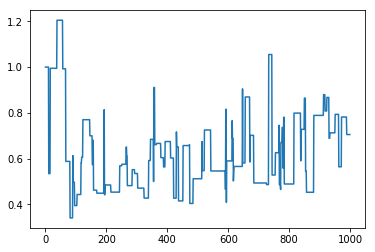

In [288]:
plt.plot(alphas)

(array([  53.,  297.,  211.,  122.,  115.,   94.,   35.,   43.,   11.,   19.]),
 array([ 0.34024287,  0.42670935,  0.51317583,  0.5996423 ,  0.68610878,
         0.77257526,  0.85904174,  0.94550821,  1.03197469,  1.11844117,
         1.20490765]),
 <a list of 10 Patch objects>)

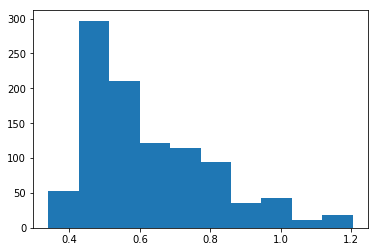

In [289]:
plt.hist(alphas)

(array([  55.,  180.,  265.,  277.,  159.,   28.,    6.,   13.,    9.,    8.]),
 array([ 0.34294568,  0.46003591,  0.57712614,  0.69421637,  0.81130659,
         0.92839682,  1.04548705,  1.16257728,  1.27966751,  1.39675774,
         1.51384797]),
 <a list of 10 Patch objects>)

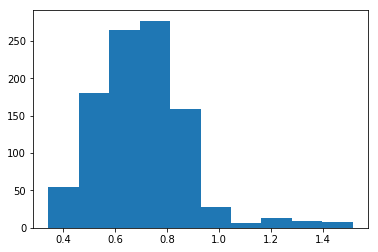

In [290]:
plt.hist(betas)

In [352]:
def run_simulation_mh(pop_alpha, pop_beta, N, guess_alpha=1, guess_beta=1, niter=1000):
    measurements = get_measurements(pop_alpha, pop_beta, N=N)
    
    plt.hist(np.median(measurements, axis=1), normed=True, label="Data")
    plt.plot(np.linspace(0, 1, 100), stats.beta(pop_alpha, pop_beta).pdf(np.linspace(0, 1, 100)), label="Population")
    plt.plot(np.linspace(0, 1, 100), stats.beta(guess_alpha, guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")
    plt.legend()
    plt.show()
    
    alphas = np.zeros(niter)
    betas = np.zeros(niter)
    
    alphas[0] = guess_beta
    betas[0] = guess_beta

    # Gibbs Sampling
    for i in range(1, niter):
        if i % 100 == 0:
            print "{0:0.1f}% Done                   \r".format(100. * i / float(niter)),
        # Draw x_i ~ P(x_i | alpha_i-1, beta_i-1)
        samples = get_samples(alphas[i - 1], betas[i - 1], measurements)
        # Draw alpha_i ~ P(alpha_i | x_i, beta_i-1)
        alphas[i] = get_alpha_mh(alphas[i - 1], betas[i - 1], samples)
        # Draw beta_i ~ P(beta_i | x_i, alpha_i)
        betas[i] = get_beta_mh(alphas[i], betas[i - 1], samples)
    
    best_guess_alpha = np.median(alphas)
    best_guess_beta = np.median(betas)
    
    f, (ax1, ax2, ax3) = plt.subplots(3)
    ax1.hist(alphas)
    ax2.hist(betas)
    
    ax3.hist(np.median(measurements, axis=1), normed=True, label="Data")
    ax3.plot(np.linspace(0, 1, 100), stats.beta(best_guess_alpha, best_guess_beta).pdf(np.linspace(0, 1, 100)), label="Guess")
    ax3.legend()
    plt.tight_layout()
    plt.show()
    
    return alphas, betas

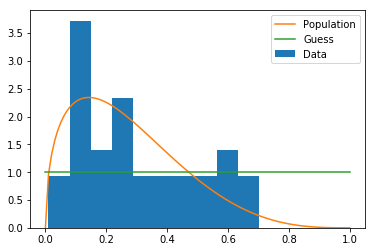

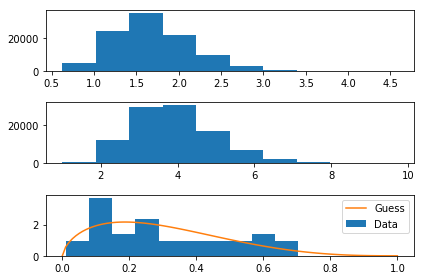

In [353]:
alphas, betas = run_simulation_mh(1.5, 4, 31, niter=100000)

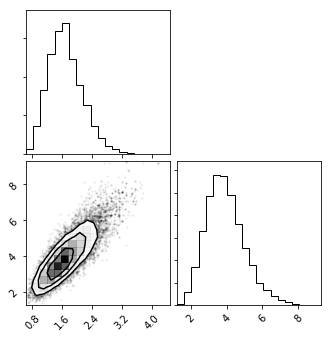

In [354]:
burn_in = 0.25
thin = 0.25

alphas_good = alphas[int(burn_in * len(alphas))::int(1/thin)]
betas_good = betas[int(burn_in * len(betas))::int(1/thin)]

samples = np.vstack((alphas_good, betas_good)).T
figure = corner.corner(samples)

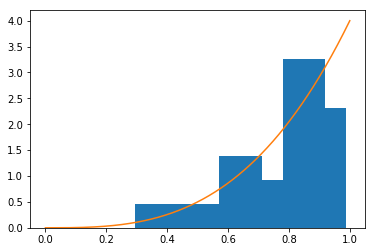

In [377]:
a, b = 4, 1
plt.hist(np.median(get_measurements(a, b, N=31), axis=1), normed=True)
plt.plot(np.linspace(0, 1, 1000), stats.beta(a, b).pdf(np.linspace(0, 1, 1000)))

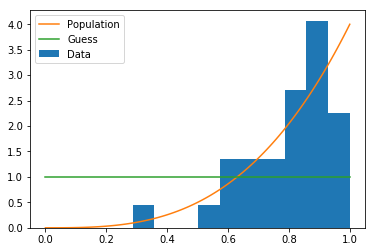

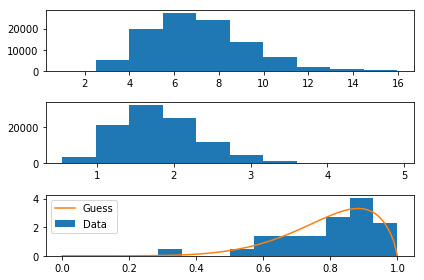

In [378]:
alphas, betas = run_simulation_mh(4, 1, 31, niter=100000)

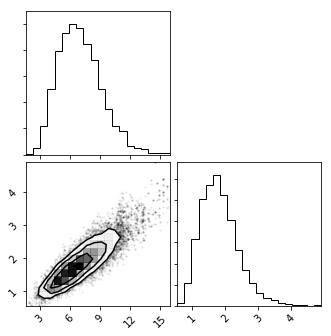

In [379]:
burn_in = 0.25
thin = 0.25

alphas_good = alphas[int(burn_in * len(alphas))::int(1/thin)]
betas_good = betas[int(burn_in * len(betas))::int(1/thin)]

samples = np.vstack((alphas_good, betas_good)).T
figure = corner.corner(samples)

(array([  982.,   993.,  1026.,  1031.,   980.,   949.,  1000.,   993.,
         1038.,  1008.]),
 array([  2.45605257e-05,   1.00019196e-01,   2.00013831e-01,
          3.00008467e-01,   4.00003102e-01,   4.99997737e-01,
          5.99992373e-01,   6.99987008e-01,   7.99981643e-01,
          8.99976279e-01,   9.99970914e-01]),
 <a list of 10 Patch objects>)

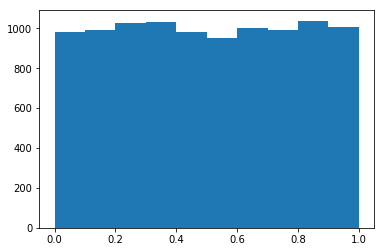

In [404]:
plt.hist(np.random.uniform(size=10000))

In [408]:
acor.acor(alphas)

(110.26985228308953, 7.055695381078362, 0.07136555644262327)

In [423]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]


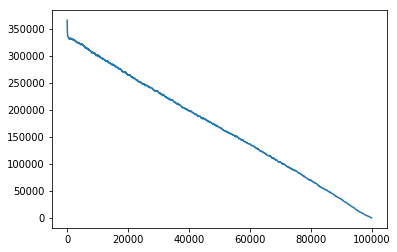

In [425]:
plt.plot(autocorr(betas))

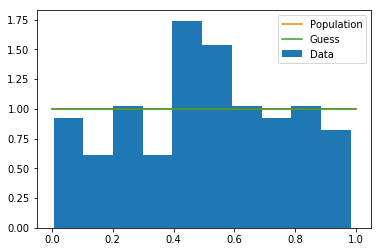

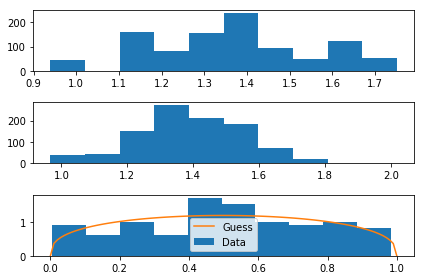

In [433]:
alphas_unif, betas_unif = run_simulation_mh(1, 1, 100, niter=1000)

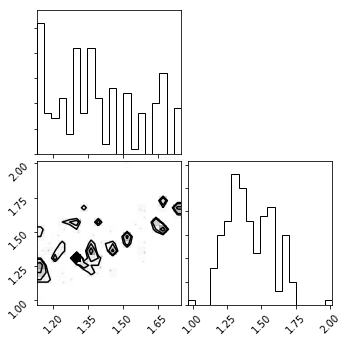

In [434]:
burn_in = 0.25
thin = 0.25

alphas_good = alphas_unif[int(burn_in * len(alphas_unif))::int(1/thin)]
betas_good = betas_unif[int(burn_in * len(betas_unif))::int(1/thin)]

samples = np.vstack((alphas_good, betas_good)).T
figure = corner.corner(samples)